### The cell below imports for the turbosensei package and functions file

In [1]:
#1
#import turbosensei as fs

import TRMPINT as tp

### This cell will open a data file selection tool

In [2]:
#2
fc = tp.FORCfile()

FileChooser(path='C:\Users\evieb\PhD\PhD stuff\PhD\TRMPINT', filename='', show_hidden='False')

### Next with initiate the ```X``` dictionary and include the selected file name

In [3]:
#3
if ('X' in locals()) == False:
    X = {}

X["fn"] = fc.selected

### We can now open a window with preprocessing options

### We can now load the data and perform the selected preprocessing 

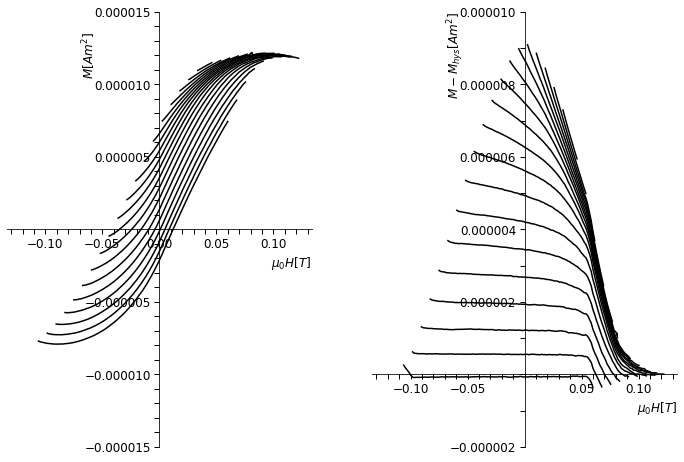

In [4]:
#4
#process data
style = {'description_width': 'initial'} #general style settings
fn = X['fn'] #print path to md.frc
sample, unit, mass = tp.sample_details(fn)

sample_widge = tp.widgets.Text(value=sample,description='Sample name:',style=style) #dont think these do anything
prop_title = tp.widgets.HTML(value='<h3>Sample preprocessing options</h3>')
mass_title = tp.widgets.HTML(value='To disable mass normalization use a value of -1')
if mass == "N/A":
    mass_widge = tp.widgets.FloatText(value=-1, description = 'Sample mass (g):',style=style)
else:
    mass_widge = tp.widgets.FloatText(value=mass, description = 'Sample mass (g):',style=style)
mass_widge1 = tp.HBox([mass_widge,mass_title])

X["sample"] = sample_widge
X["mass"] = mass_widge
X["unit"] = unit

H, Hr, M, Fk, Fj, Ft, dH = tp.parse_measurements(X["fn"])
Hcal, Mcal, tcal = tp.parse_calibration(X["fn"])
Hc1, Hc2, Hb1, Hb2 = tp.measurement_limts(X)

# make a data dictionary for passing large numbers of arguments
    # should unpack in functions for consistency
X["H"] = H
X["Hr"] = Hr
X["M"] = M
X["dH"] = dH
X["Fk"] = Fk
X["Fj"] = Fj
X["Ft"] = Ft
X["Hcal"] = Hcal
X["Mcal"] = Mcal
X["tcal"] = tcal
X["Hc1"] = Hc1
X["Hc2"] = Hc2
X["Hb1"] = Hb1
X["Hb2"] = Hb2
slope = 70.
X["slope"] = slope #set value manually for slope correction

if X['unit']=='Cgs': #mine is SI
    X = tp.CGS2SI(X)
#print(X["M"])
X = tp.drift_correction(X) #do drift correction?
#print(X["M"]) #
X = tp.slope_correction(X)
X = tp.remove_fpa(X) #changed value
#print(X["H"]) #values not changed after drift correction
X = tp.remove_lpa(X)
X = tp.lowerbranch_subtract(X)
    
fig = tp.plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
X = tp.plot_hysteresis(X,ax1)
ax2 = fig.add_subplot(122)
X = tp.plot_delta_hysteresis(X,ax2)


### Sample name before do properly

In [ ]:
name = str(input("Sample name:" ))
X['name'] = name

### Calculate the FORC distributions for the sample

In [ ]:
import cProfile
cProfile.run('tp.calc_rho(X,5)') #just do for example

In [ ]:
#6

maxSF = 5
X['maxSF1'] = maxSF
#function to get arrays for plotting
X = tp.create_arrays(X, maxSF)
#calculate FORC dsitribution for each SF
for sf in range(2, maxSF+1):
    X = tp.calc_rho(X, sf)
    sf+=1   
X = tp.nan_values(X, maxSF) 
X = tp.rotate_FORC(X)

In [ ]:
list(X)

### Find the FWHM for each sample to find the FORC distribution at SF = 0

In [ ]:
#9
fwhmlist = []
SFlist = []
for SF in range(2,maxSF+1):
    SFlist.append(SF)

for i in range(len(SFlist)):
    tp.find_fwhm(X, SFlist[i], name, fwhmlist)
    i+=1 #0,1,2,3


### Plot the FWHM for each to check it is reasonable

In [ ]:
#10
tp.plot_fwhm(SFlist, fwhmlist, X) #give Hu_0

### Check the FWHM used in calcuating SF=0 is reliable and if not correct it. 

In [ ]:
tp.check_fwhm(SFlist, fwhmlist, X)

In [ ]:
#11
X = tp.divide_mu0(X) #unsure if this is needed

### Plot FORC diagram 

In [ ]:
tp.norm_rho(X, X['sf_choose'])
tp.plot_general_FORC_basic1(X['Hc'], X['Hu'], X['rho_n'], X['sf_choose'], X['name'])

### Produce interpolated FORC distribution and make symmetrical

In [ ]:
#12
X = tp.inter_FORC(X)
X = tp.sym_FORC(X)

### Normalise symmertrical FORC diagram

In [ ]:
X = tp.norm_z(X)

### Read in NRM demag data for sample

In [ ]:
af_n = tp.af_nrm_file()

### Read in SIRM demag data for sample

In [ ]:
af_i = tp.af_irm_file()

### Prepare the demagnetisation data for the file

In [ ]:
X['af_n_fn'] = af_n.selected
X['af_i_fn'] = af_i.selected
X = tp.demag_data(X)

In [ ]:
#just one time change. 
print(X['af_nrm'])
X['af_nrm'] = X['af_nrm']/1000.
print(X['af_nrm'])

In [ ]:
while True:
        minf = (input("Pick the lower bound of field range to be tested:" ))
     
        try:
            minf = float(minf)
            if (minf > 0):# (minf <= maxSF)
                print('in bounds')
                break
        except ValueError:
            print('Not a number')
            True

while True:
        maxf = (input("Pick the upper bound of field range to be tested:" ))
     
        try:
            maxf = float(maxf)
            if (maxf > minf):
                print('in bounds')
                break
        except ValueError:
            print('Not a number')
            True

In [ ]:
#varibles unsure where to put
import numpy as np

mu0 = 4*tp.pi*1e-7
ms0 = 491880.5
kb = 1.3806503e-23
tau = 10e-9
roottwohffield = 2**(0.5)  

sumegli = 0.0
eglip=0.54
eglid=tp.log(113*((31486**(-eglip))))+0.52
eglid=113*((31486**(-eglip)))
egliin = 5.4
eglip=egliin/10.0 # 0.54 #eglin from data file
hf=(10000**(0.54))*(10**(-0.52)) #checking maths
eglid=+0.52+(tp.log10(hf)-tp.log10(10000.0)*eglip)
affield = 0
affmax = 0.0
af_step_max = 0.0
flatsub=0
flat=0


afone = 1
afzero = 0
V = {} #V dictionary mainly for variables used and changed in blockfind and check it changed them - set something and see how change
counttime = 0
V['counttime'] = counttime
blockper = 0.0
V['blockper'] = blockper

V['totalmcount'] = np.zeros(5000)
V['tempcount'] = np.zeros(5000)

afmagstore = np.zeros((100))
negsirm = np.zeros((100))
afcount = np.zeros(1000) #copy adrians size

### Variables which I aren't worth moving into a function and rely on cntfields or will rely on user input

In [ ]:
#20
num_hyss = 5000
V['num_hyss'] = num_hyss
#field limits for TRM
fieldmax=maxf/mu0
fieldmin= minf/mu0 
fieldstep=(fieldmax-fieldmin)/3. #do for 3 fields
#temp limits
tempmax=577+273 # one degree less than Tc otherwise 1/0 = NaN
tempmin=300 #lines 116
V['tempmin'] = tempmin
V['tempmax'] = tempmax
tempstep=10
#time constant
#chose number in hours 720
ac = 720 #720 
hcstore = np.zeros(num_hyss)
V['hcstore'] = hcstore
histore = np.zeros(num_hyss)
V['histore'] = histore
spacing = 1.1
field = fieldmin
ifield = 0
fields = np.zeros((100))
cntfield = X['cntfield']
cntfields = cntfield
sirm = np.zeros((cntfields, 100)) #if sirm is global it should be updated and used in function ok
aftotalmplot = np.zeros((cntfields))
demagstep = np.zeros((cntfields))
afmag = np.zeros((cntfield, 100)) #is this the same cntfield size
field = fieldmin
trm = np.zeros((cntfield, 500))

### Code to run the main model

In [ ]:
#full field loop
from math import log

while (field < (fieldmax)): # 0.0000001

    print('counttime start field', V['counttime'])
    print(field , 'field')
    V['countiold'] = num_hyss 
    #countiold = V['countiold']
    blockg = np.zeros(num_hyss) #line 349
    boltz = np.zeros(num_hyss)
    blocktemp = np.zeros(num_hyss) 
    af_step = X['af_step']
    V['blocktemp'] = blocktemp
    V['boltz'] = boltz
    V['blockg'] = blockg
    V['totalm'] = 0
    V['sir'] = 0
    V['aftotalm'] = 0
    partvol = 0.0
    i=0 #is this i=1 or i=0?
    hctot = 0
    hitot=0
    ranvtot=0 #defined earlier too?
    switch=0
    countsf=0
    countsfnew=0
    tempvol=0.0 #these used in pop_hys - need tidy up
    hicount=0
    temp=300
    tempt=300
    ms=ms0*(1-(tempt-273)/578.0)**0.43 
    V['ms'] = ms
    tm = 0.2 #change from 0.2 to 0.1 for line 43 # typical forc measuring time, poss use 0.1
    V['tm'] = tm
    sense = np.ones(num_hyss) #run after hys, num_pop
    V['sense'] = sense
    temp = tempmax
    rate = 1 
    V['rate'] = rate
    V['totalblocktwo'] = 0
    V['totalblock'] = 0
    V['totalmomentarray'] = np.zeros(5000) #maybe note set to zero here
    V['totalmoment'] = 0
    #just for test
    afswitch = afzero
    hys, num_pop = tp.pop_hys(num_hyss, X, V) #called later here? 
    V['hys'] = hys
    #TRM acquition
    tm = 0
    aftotalm = 0
    V['aftotalm'] = aftotalm
    V['tm'] = tm #to use for af demag bit delcare here

    while (temp > tempmin):
        aconst=(-ac*60.0*60.0)/(log(0.01*(tempmin)/(tempmax-tempmin))) #line 708 
        V['aconst'] = aconst
        beta= (1-(temp-273)/578.0)**0.43
        V['beta'] = beta
        tp.blockfind(temp, field, afzero, V, X) #does counttime change in blockfind
        V['totalmcount'][V['counttime']] = V['totalm']
        V['tempcount'][V['counttime']] = temp
        V['totalmomentarray'][V['counttime']] = V['totalmoment']
        temp = temp - tempstep

    counttime = V['counttime'] #get value back
    counttimetrm = counttime
    print('countime end of TRM', counttimetrm)
    rate = 0
    V['rate'] = rate
    tm = 60
    V['tm'] = tm
    temp = tempmin + tempstep
    beta = (1 - (temp - 273)/578.0)**0.43
    fieldzero = 0.0
    tp.blockfind(temp, fieldzero, afzero, V, X) #check if totalm, spcounti work still
    counttime = counttime - 1
    V['counttime'] = counttime
    #calc AF demag of TRM at 273 K

    afmag[ifield, 0] = V['totalm'] #set value here #afmag is 2 thing? and check right totalm
    print('temp of AF demag', temp)
    for i in range(cntfield):
        for kk in range(1): # do once
            afstore = af_step[i]
            V['afstore'] = afstore
            tp.blockfind(temp, fieldzero, afone, V, X) #unsure about aftotalm - output 
            V['totalmcount'][V['counttime']] = V['aftotalm']
            V['tempcount'][V['counttime']] = temp #should be tempaf
            afcount[V['counttime']] = afstore
            aftotalmplot[i] = V['aftotalm']
            demagstep[i] = af_step[i]
            afmag[ifield, i] = V['aftotalm'] #af mag for each field and cnt step - 3 lines of total m for af demag
    
    print('counttime end of AF demag of TRM (think)', V['counttime'])
    #re-normalize?
    j = ifield 
    #afmagstore = np.zeros((100)) #do i want to initate this here
    
    #assume zero unless told otherwise unsure in code
    cntfieldaf = 0
    afmagstore[j] = afmag[j,cntfieldaf] #lne not work 
    afstore = 0.0
    V['afstore'] = afstore
    
    #calc SIRM at 273 K
    #line 832
    #temp = 273 # set temp
    print('temp of SIRM deamg', temp)
    blockg = np.ones(num_hyss)
    boltz = np.ones(num_hyss)
    blocktemp = np.ones(num_hyss) 
    V['blocktemp'] = blocktemp
    V['boltz'] = boltz
    V['blockg'] = blockg
    #print('blockg match one above', V['blockg'])
    fieldzero = 0.0
    #aftotalm referred to as sir
    V['sir'] = 0
    tp.blockfind(temp, fieldzero, afone, V, X)
    #print(V['blockg'])
    V['totalmcount'][V['counttime']] = V['sir']  #line 844 #do i need to call this befre
    V['tempcount'][V['counttime']] = temp #should be temp
    cntfields = cntfield #where this come from?
    
    #print('ifield', ifield, 'sirm', V['sir'])
    
    sirm[ifield,0] = V['sir'] #just running once, same idea as afmagstore ?? 

    sirmtotalmplot = np.zeros((25))
    demagstep = np.zeros((25))

    for i in range(cntfield): 
        for kk in range(1):
            afstore = af_step[i]
            V['afstore'] = afstore
            print(afstore)
            tp.blockfind(temp, fieldzero, afone, V, X)
            #print('sir', sir)
            #does blockfind use sir in it
            #print('ifield', ifield, 'i', i, 'sirm value', V['sir'])
            sirm[ifield,i] = V['sir'] #rewrite the first point?
            print(V['sir'])
            sirmtotalmplot[i] = V['sir']
            demagstep[i] = af_step[i]
            V['totalmcount'][V['counttime']] = V['sir'] #line 844 #do i need to call this befre
            V['tempcount'][V['counttime']] = temp #should be temp
    
    fields[ifield] = field
    field = field + fieldstep
    counttime = V['counttime']
    counttime = counttime +1 #still within field loop but after adding onto next field
    V['counttime'] = counttime
    negs = 0.0 #negative sirm??
    
    negsirm[ifield] = -negs
    
    ifield = ifield +1 #end of loop for field
    V['aconst'] = aconst
    V['afmag'] = afmag
    V['sirm'] = sirm #use to plot from dictionary
    V['ifield'] = ifield
    V['fields'] = fields
    print('counttime end loop, after SIRM', counttime)
    

### Test model has reproduced measured SIRM demagnetisation spectra

In [ ]:
print(V['sirm'])
for i in range(20):
    print(V['sirm'][0,i])

In [ ]:
tp.sirm_test(V, X)

In [ ]:
print(X['af_irm'])


### Processing to calculate the palaeointensity

In [ ]:
X,V = tp.calc_pal(X,V)

### Plot the SIRM reliability spectras

In [ ]:
tp.plot_sirm_check(X,V)

### Plot the palaeointensity calculated for each AF demagnetisation step, and plot a table of the index of each AF step to help with the next section

In [ ]:
tp.plot_pal(V,X)

### Calculate the final palaeintensity estimation by picking the platau region by sight using the information above and the Zdjerveld plot

In [ ]:
tp.fin_pal(X,V)